# Relation of power production from renewables to LSWRs

In [21]:
%load_ext autoreload
%autoreload 2
import pathlib
import string

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import a6
import a6.plotting._colors as _colors

a6.utils.logging.create_logger(
    global_rank=0,
    local_rank=0,
    verbose=False,
)

path = pathlib.Path(
    "/p/project1/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12.nc"
)
plots = pathlib.Path("/p/project1/deepacf/emmerich1/plots/paper-2")
pca_dir = pathlib.Path("/p/scratch/deepacf/emmerich1/pca")
kmeans_dir = pathlib.Path("/p/project1/deepacf/emmerich1/data/kmeans")

alphabet = list(string.ascii_lowercase)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%time

ds = xr.open_dataset(path)

coordinates = a6.datasets.coordinates.Coordinates()
variables = a6.datasets.variables.Model()

ds

CPU times: user 511 ms, sys: 104 ms, total: 615 ms
Wall time: 3.31 s


<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 141, level: 5, time: 21826)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * level      (level) int32 300 500 700 850 950
  * time       (time) datetime64[ns] 1964-01-01T12:00:00 ... 2023-10-03T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 17:05:15 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Plotting

In [4]:
import matplotlib.ticker


results = xr.open_dataset(
    "/p/project1/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40.nc"
)

n_lswr_categories = 30
results_pca_kmeans = results.sel(k=n_lswr_categories)
gwl = xr.open_dataset(
    "../src/tests/data/gwl.nc"
)

# NOTE: Uncomment to save dcv2 to disk, or read from disk
# dcv2 = torch.load(
#     "/p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-30/epoch-799-assignments.pt",
#     map_location=torch.device("cpu"),
# )
# dcv2 = xr.DataArray(
#     # Need to add +1 to be conform with GWL labels
#     dcv2.numpy()[0] + 1,
#     name="DCv2",
#     coords={"time": results["time"]},
#     dims=["time"],
# )
# dcv2.to_netcdf("/p/project1/deepacf/emmerich1/data/dcv2-lswrs.nc")

dcv2 = xr.open_dataset("/p/project1/deepacf/emmerich1/data/dcv2-lswrs.nc")[
    "DCv2"
]

lswrs = [dcv2, results_pca_kmeans["PCA"], gwl["GWL"]]

In [15]:
gwl_labels_map = {int(k): v for k, v in gwl.attrs.items()}
gwl_labels = list(gwl_labels_map.values())
gwl_labels_map, gwl_labels

({1: 'XXAAT',
  2: 'NOAAT',
  3: 'SOAAT',
  4: 'SWAAT',
  5: 'NWAAT',
  6: 'XXAAF',
  7: 'NOAAF',
  8: 'SOAAF',
  9: 'SWAAF',
  10: 'NWAAF',
  11: 'XXAZT',
  12: 'NOAZT',
  13: 'SOAZT',
  14: 'SWAZT',
  15: 'NWAZT',
  16: 'XXAZF',
  17: 'NOAZF',
  18: 'SOAZF',
  19: 'SWAZF',
  20: 'NWAZF',
  21: 'XXZAT',
  22: 'NOZAT',
  23: 'SOZAT',
  24: 'SWZAT',
  25: 'NWZAT',
  26: 'XXZAF',
  27: 'NOZAF',
  28: 'SOZAF',
  29: 'SWZAF',
  30: 'NWZAF',
  31: 'XXZZT',
  32: 'NOZZT',
  33: 'SOZZT',
  34: 'SWZZT',
  35: 'NWZZT',
  36: 'XXZZF',
  37: 'NOZZF',
  38: 'SOZZF',
  39: 'SWZZF',
  40: 'NWZZF'},
 ['XXAAT',
  'NOAAT',
  'SOAAT',
  'SWAAT',
  'NWAAT',
  'XXAAF',
  'NOAAF',
  'SOAAF',
  'SWAAF',
  'NWAAF',
  'XXAZT',
  'NOAZT',
  'SOAZT',
  'SWAZT',
  'NWAZT',
  'XXAZF',
  'NOAZF',
  'SOAZF',
  'SWAZF',
  'NWAZF',
  'XXZAT',
  'NOZAT',
  'SOZAT',
  'SWZAT',
  'NWZAT',
  'XXZAF',
  'NOZAF',
  'SOZAF',
  'SWZAF',
  'NWZAF',
  'XXZZT',
  'NOZZT',
  'SOZZT',
  'SWZZT',
  'NWZZT',
  'XXZZF',
  'NOZZF',
 

## Clean production data for plotting

In [ ]:
%%time

"""
NOTE: Preprocess turbine data. This takes ~22 min, so prefer loading (cell below)
if no changes to the preprocessing are required.
"""

paths = list(
    pathlib.Path("/p/home/jusers/emmerich1/juwels/data/production").glob(
        "**/*.nc"
    )
)
print(paths)


def remove_outliers(data: xr.Dataset) -> xr.Dataset:
    power_rating = float(data.attrs["power rating"].split()[0])
    print(power_rating)
    # Only use data points where
    # - production is lower than power rating
    # - production is greater than 0
    return a6.datasets.methods.turbine.clean_production_data(
        power_rating=power_rating,
    ).apply_to(data)


# Contains the turbine name and the production
turbines: dict[str, xr.Dataset] = {
    path.name: remove_outliers(xr.open_dataset(path)) for path in paths
}

# NOTE: Uncomment to save preprocessed data to disk.

for name, data in turbines.items():
    data.to_netcdf(
        f"/p/home/jusers/emmerich1/juwels/data/production-cleaned-for-analysis/{name}.nc"
    )

In [5]:
# Open preprocessed turbine data if available
paths = list(
    pathlib.Path(
        "/p/home/jusers/emmerich1/juwels/data/production-cleaned-for-analysis"
    ).glob("**/*.nc")
)
# Contains the turbine name and the production
turbines: dict[str, xr.Dataset] = {
    path.name: xr.open_dataset(path) for path in paths
}

## Relation of LSWRs to Power Production

In [6]:
%%time

import dataclasses
import datetime


@dataclasses.dataclass
class PowerPerMode:
    label: int
    measurements: list[int] = dataclasses.field(default_factory=list)
    sum: list[float] = dataclasses.field(default_factory=list)
    mean: list[float] = dataclasses.field(default_factory=list)
    std: list[float] = dataclasses.field(default_factory=list)
    normalized_mean: list[float] = dataclasses.field(default_factory=list)
    normalized_std: list[float] = dataclasses.field(default_factory=list)


def get_power_per_lswr(data: xr.Dataset) -> dict[int, PowerPerMode]:
    modes = a6.modes.methods.determine_lifetimes_of_modes(data)
    dates = [xr.DataArray(list(mode.get_dates())) for mode in modes]

    power_per_mode = {
        mode.label: PowerPerMode(label=mode.label) for mode in modes
    }

    for i, (name, turbine) in enumerate(turbines.items()):
        print(f"{data.name}: {i}/{len(turbines)}", end="\r")
        power_rating = float(turbine.attrs["power rating"].split()[0])

        # Resample to daily production and calculate sum, relative mean and std
        resampled = turbine["production"].resample({"time": "1d"}, skipna=True)
        daily_sum = resampled.sum(skipna=True)
        daily_mean = resampled.mean(skipna=True)
        daily_mean_normalized = daily_mean / power_rating
        daily_std = resampled.std(skipna=True)
        daily_std_normalized = daily_std / power_rating

        for mode, date in zip(modes, dates, strict=True):
            mode_power = power_per_mode[mode.label]

            # Get time steps of production where LSWR appeared
            intersection = sorted(set(daily_sum.time.values) & set(date.values))

            # if not intersection:
            #     print(f"WARNING: empty intersection for {name} and mode {mode.label}")
            #     continue

            # Count number of days that contribute to the results
            mode_power.measurements.append(len(intersection))

            # Select time steps of LSWR appearance and calculate sum
            total = daily_sum.sel(time=intersection)
            mode_power.sum.extend(total.values.flatten().tolist())

            # Select time steps of LSWR appearance and calculate mean
            mean = daily_mean.sel(time=intersection)
            mean_normalized = daily_mean_normalized.sel(time=intersection)
            mode_power.mean.extend(mean.values.flatten().tolist())
            mode_power.normalized_mean.extend(
                mean_normalized.values.flatten().tolist()
            )

            # Select time steps of LSWR appearance and calculate std
            std = daily_std.sel(time=intersection)
            std_normalized = daily_std_normalized.sel(time=intersection)
            mode_power.std.extend(std.values.flatten().tolist())
            mode_power.normalized_std.extend(
                std_normalized.values.flatten().tolist()
            )
    return power_per_mode


power_per_method = {lswr.name: get_power_per_lswr(lswr) for lswr in lswrs}

CPU times: user 4min 3s, sys: 11.3 s, total: 4min 14s
Wall time: 4min 16s


In [28]:
power_per_method["DCv2"][1].normalized_mean

[0.3963222975668129,
 nan,
 nan,
 0.33927376970855233,
 0.15265132139812446,
 0.29732998885172796,
 0.12304015930965816,
 0.6325885668276973,
 0.1367806763285024,
 0.257956204379562,
 0.3611377893142981,
 0.4748731884057971,
 0.4383675523349437,
 0.2649592391304348,
 0.3527999194847021,
 0.5843941223832528,
 0.29673107890499195,
 0.13116872756282408,
 0.5885136501516683,
 0.17014942141332434,
 0.6647742244580189,
 nan,
 0.6006763285024155,
 0.14869565217391303,
 nan,
 nan,
 0.06818840579710145,
 0.5621980676328502,
 0.0706839562674803,
 0.12051307679493586,
 0.8628180354267311,
 0.5797604669887279,
 0.8111433172302738,
 0.3563305152979066,
 0.6547041062801932,
 0.23202361782071929,
 0.2963419020416799,
 0.4509863123993559,
 0.12810758082497214,
 0.07664109121909635,
 0.5305919921395235,
 0.8051308373590982,
 0.8327958937198068,
 0.4353482286634461,
 0.19210748792270532,
 0.06276214833759591,
 0.03937520128824477,
 0.20860157640478005,
 0.2896425120772947,
 0.10875431331953071,
 nan,
 0

In [ ]:
import pandas as pd

latex_code = []


def power_mean_with_std_as_string(stats: list[float]) -> str:
    return f"${np.nanmean(stats) * 100:.2f} \pm {np.nanstd(stats) * 100:.2f}$"


columns = {
    "$N$": lambda lswrs: [
        np.nansum(results.measurements) for results in lswrs.values()
    ],
    "$P_{\mathrm{total}}$ [kW]": lambda lswrs: [
        f"{int(np.nansum(results.sum)):d}" for results in lswrs.values()
    ],
    "$P^{\mathrm{mean}}_{\mathrm{normalized}}$ [\%]": lambda lswrs: [
        power_mean_with_std_as_string(results.normalized_mean)
        for results in lswrs.values()
    ],
    "$P^{\mathrm{std}}_{\mathrm{normalized}}$ [\%]": lambda lswrs: [
        power_mean_with_std_as_string(results.normalized_std)
        for results in lswrs.values()
    ],
}

reform = {
    (name, column): func(method)
    for name, method in power_per_method.items()
    for column, func in columns.items()
}

df = pd.DataFrame.from_dict(reform)

# Add 1 to start indexing at 1 to be conform with LSWR labels
df.index += 1

code = df.to_latex(
    float_format="%.2f",
    label="production-per-lswr-per-method",
    caption=f"Power production for the resulting LSWRs.",
)


with open(
    "/p/home/jusers/emmerich1/juwels/code/a6/notebooks/power-production-table.tex",
    "w",
) as f:
    f.write(code)

df

DCv2
PCA
GWL
label mean	median	95-quantile		mean	median	95-quantile		mean	median	95-quantile		
1 	 34.7	27	88			35.7	28	83			20.9	16	62
2 	 24.0	20	58			20.0	16	50			25.8	21	62
3 	 26.9	22	66			22.0	16	60			26.3	22	58
4 	 31.3	25	79			57.7	58	96			25.2	20	61
5 	 29.1	24	69			32.1	26	77			37.7	33	85
6 	 32.8	28	79			59.8	61	96			17.0	13	43
7 	 33.7	28	79			38.6	36	81			22.9	19	51
8 	 20.2	16	52			37.0	32	85			24.0	26	37
9 	 23.2	18	62			38.8	35	88			32.2	25	86
10 	 15.6	13	36			19.2	15	49			41.1	37	86
11 	 32.4	28	73			27.0	22	69			16.1	12	41
12 	 16.6	14	42			19.0	15	48			25.6	21	60
13 	 47.4	46	92			32.5	25	84			23.2	22	48
14 	 17.2	15	40			55.9	57	95			35.9	31	83
15 	    	 	  			41.6	40	81			39.3	33	88
16 	    	 	  			39.0	35	82			15.3	11	38
17 	    	 	  			27.7	24	64			16.8	16	30
18 	    	 	  			30.1	26	72			19.0	14	43
19 	    	 	  			21.3	17	53			28.6	22	77
20 	    	 	  			20.1	17	48			44.1	40	96
21 	    	 	  			29.8	26	73			18.7	15	47
22 	    	 	  			43.4	38	92			76.4	79	100
23 	 

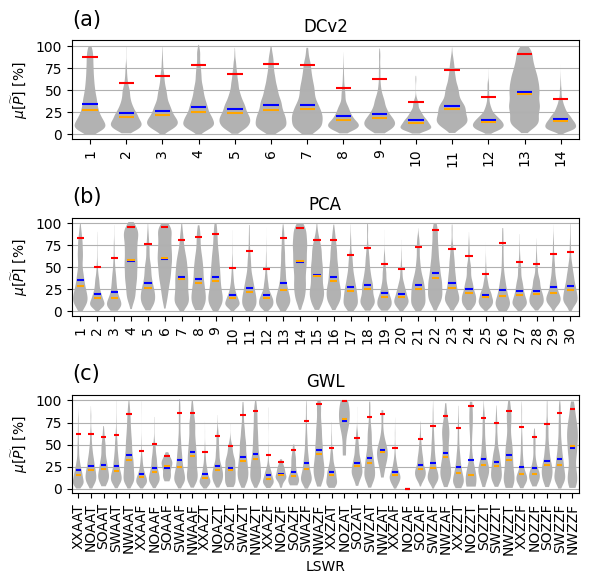

In [38]:
import matplotlib.pyplot as plt


def plot_power_per_mode(
    powers: dict[str, dict[int, PowerPerMode]],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the power production for each LSWR and method."""
    n_rows = len(powers)
    n_cols = 1
    # colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6 * n_cols, 2 * n_rows),
        nrows=n_rows,
        ncols=n_cols,
        sharey=True,
    )

    plt.title(f"Power production per LSWRs")

    paths = []

    for i, (method, powers_per_lswr) in enumerate(powers.items()):
        print(method)
        labels = np.arange(1, len(powers_per_lswr.keys()) + 1, dtype=int)
        x_lims = labels.min() - 0.5, labels.max() + 0.5

        power_means = [
            np.array(power.normalized_mean) * 100.0
            for power in powers_per_lswr.values()
        ]
        # filter NaN
        power_means = [
            x[~np.isnan(x)] for x in power_means
        ]
        # Ensure that all arrays contain at least one value
        power_means = [
            x if x.size > 0 else np.array([0.0]) for x in power_means
        ]
        ax = axs[i]

        parts = axs[i].violinplot(
            power_means,
            widths=0.85,
            showmeans=True,
            showmedians=True,
            showextrema=False,
            quantiles=[[0.95] for _ in enumerate(power_means)],
        )

        parts["cmeans"].set_color("blue")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        parts["cquantiles"].set_color("red")

        for pc in parts["bodies"]:
            pc.set_facecolor("black")
            pc.set_alpha(0.3)

        ax.set_title(method)

        if i == n_rows - 1:
            ax.set_xlabel("LSWR")

        ax.set_ylabel(r"$\mu\left[ \widetilde{P} \right]$ [%]")
        ax.set_xlim(*x_lims)
        ax.set_xticks(labels)
        xticklabels = gwl_labels if method == "GWL" else labels
        ax.set_xticklabels(xticklabels, rotation=90)

        ax.set_yticks([0, 25, 50, 75, 100])

        ax.yaxis.grid(True)

        ax.annotate(
            f"({alphabet[i]})",
            xy=(0.0, 1.15),
            xycoords="axes fraction",
            fontsize=15,
        )

        paths.append(
            list(
                zip(
                    parts["cmeans"]._paths,
                    parts["cmedians"]._paths,
                    parts["cquantiles"]._paths,
                )
            )
        )


    fig.tight_layout()
    plt.savefig(plots / "lswrs-power-production-comparison.pdf")

    print("label", 3 * "mean\tmedian\t95-quantile\t\t")
    for i in range(40):

        def _get_values(p):
            try:
                mean, median, quantile = p[i]
                return (
                    f"{mean._vertices[0][-1]:.1f}",
                    f"{median._vertices[0][-1]:.0f}",
                    f"{quantile._vertices[0][-1]:.0f}",
                )
            except IndexError:
                return "   ", " ", "  "

        a = "\t".join(
            _get_values(paths[0])
            + ("\t",)
            + _get_values(paths[1])
            + ("\t",)
            + _get_values(paths[2])
        )
        print(i + 1, "\t", a)


plot_power_per_mode(power_per_method)